# Global Monsoon pattern

In this tutorial we show how the Global Monsoon index as it is defined by Wang et al. 2008 is derived.


In [2]:
import numpy as np
import geoutils.plotting.plots as gplt
import geoutils.geodata.base_dataset as bds
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.tsa.propagation as prop
import geoutils.tsa.pca.eof as eof
import geoutils.tsa.pca.multivariate_pca as mvpca
import geoutils.utils.general_utils as gut
from importlib import reload

plot_dir = "/home/strnad/data/plots/tutorials/global_monsoon/"
data_dir = "/home/strnad/data/"

In [30]:
# Load the dataset
grid_step = 1
dataset_file = data_dir + \
    f"climate_data/{grid_step}/mswep_pr_{grid_step}_ds.nc"

lon_range_cut = [-180, 180]
lat_range_cut = [-50, 50]

ds_pr = bds.BaseDataset(data_nc=dataset_file,
                        can=True,
                        an_types=['dayofyear', 'month', 'JJAS'],
                        lon_range=lon_range_cut,
                        lat_range=lat_range_cut,
                        verbose=False,
                        )

Created dayofyearly anomalies!
Rename pr to pr_an_dayofyear!
Created monthly anomalies!
Rename pr to pr_an_month!
Created JJASly anomalies!
Rename pr to pr_an_JJAS!


Now we perform an EOF analysis of the precipitation field


Univariate PCA var with dataarray
Explained variance: 0.5914621353149414


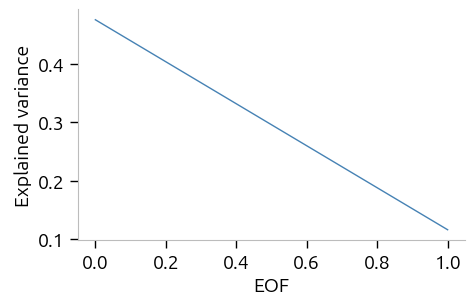

In [88]:
reload(tu)
n_components = 2
input_data = ds_pr.ds['pr']
# input_data is the 12 month climatology
# This create a time series of the mean precipitation in the region per month/day
timemean = 'dayofyear'
yearly_mean_pr = tu.compute_timemean(input_data,
                                     timemean=timemean,
                                     groupby=True,
                                     reset_time=True,  # important for EOF labeling
                                     )

reload(eof)
reload(mvpca)
sppca = mvpca.MultivariatePCA(yearly_mean_pr, n_components=n_components)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
gut.myprint(f"Explained variance: {np.sum(sppca.explained_variance())}")
im = gplt.plot_xy(y_arr=sppca.explained_variance(),
                  xlabel='EOF', ylabel='Explained variance',
                  ylog=False, figsize=(5, 3))

Now plot the EOF and their corresponding PC time series.


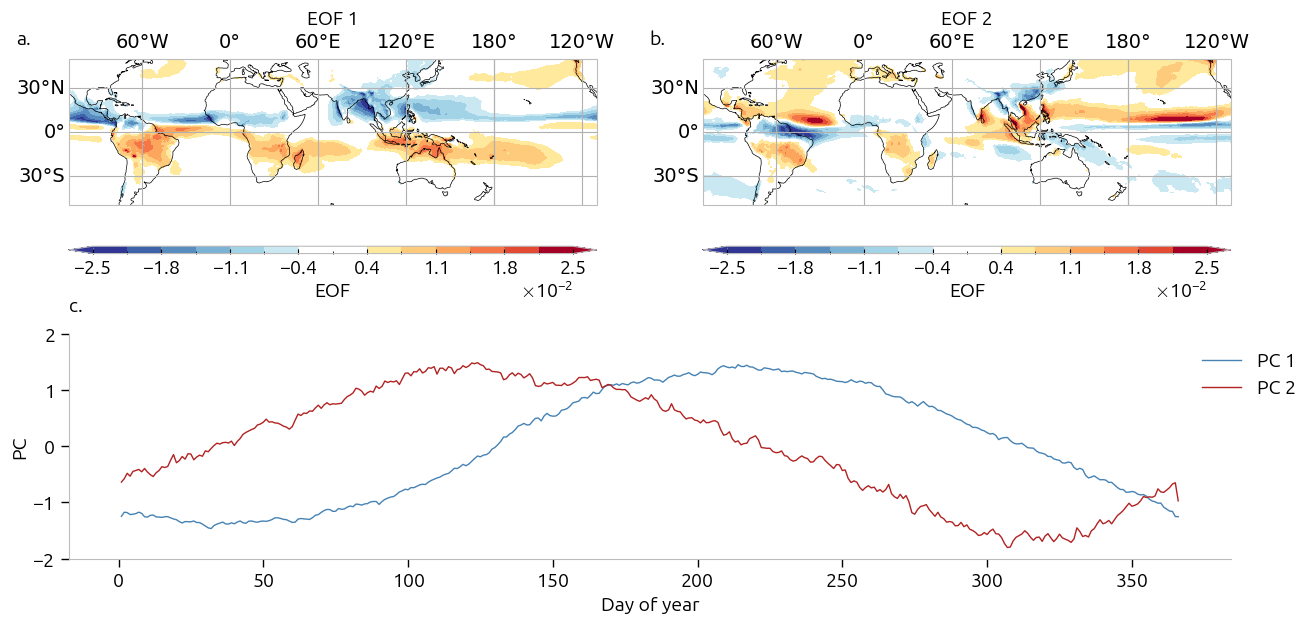

In [87]:
# EOF maps
reload(gut)
nrows = 1
ncols = n_components
im = gplt.create_multi_plot(nrows=2, ncols=ncols,
                            hspace=0.4,
                            wspace=0.2,
                            full_length_row=True,
                            figsize=(15, 7),
                            proj_arr=['PlateCarree',
                                      'PlateCarree', None],
                            end_idx=3,
                            central_longitude=70,
                            )
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    im_eof = gplt.plot_map(comp,
                           ax=im['ax'][i],
                           vmin=-.025, vmax=.025,
                           cmap='RdYlBu_r',
                           levels=14,
                           title=f'EOF {i+1}',
                           centercolor='white',
                           label='EOF',
                           )


# Now we plot the PCs
pcs = sppca.get_principal_components()
for i in range(sppca.n_components):
    gplt.plot_xy(
        ax=im['ax'][2],
        x_arr=[pcs['time']],
        y_arr=[-1*pcs.sel(eof=i)],
        xlabel='Day of year',
        ylabel=f'PC',
        figsize=(6, 3),
        color=gplt.colors[i],
        label_arr=[f'PC {i+1}'],
        loc='outside',
        ylim=[-2, 2],
        set_axis=True,
    )
savepath = plot_dir +\
    f"/gm_eofs.png"
gplt.save_fig(savepath, fig=im['fig'])

## Definition of global monsoon regions

Global monsoon regions are defined by regions where the summer - winter precipitation exceeds 2mm/day and about 60% of the annual rainfall is in JJAS


Select data from Jun - Sep!
Select data from Dec - Mar!


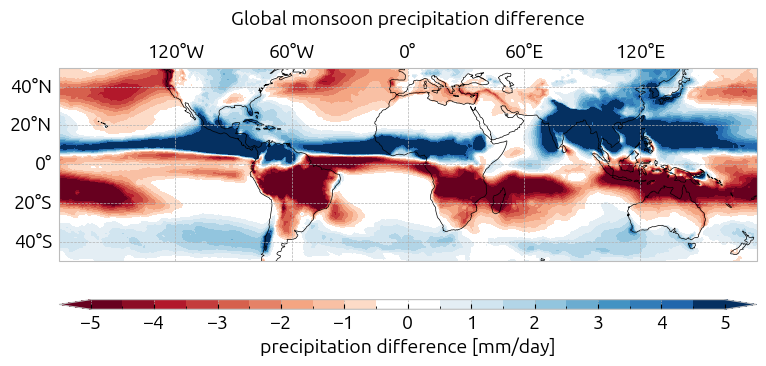

In [69]:
input_data = ds_pr.ds['pr']
pr_jjas = tu.get_month_range_data(input_data, 'Jun', 'Sep')
pr_djfm = tu.get_month_range_data(input_data, 'Dec', 'Mar')

diff_pr = tu.compute_mean(pr_jjas) - tu.compute_mean(pr_djfm)
abs_diff_pr = np.abs(diff_pr)
im_diff = gplt.plot_map(diff_pr,
                        vmin=-5, vmax=5,
                        cmap='RdBu',
                        title=f'Global monsoon precipitation difference',
                        centercolor='white',
                        label='precipitation difference [mm/day]',
                        levels=20,
                        )
savepath = plot_dir +\
    f"/gm_pr_diff.png"
gplt.save_fig(savepath, fig=im['fig'])

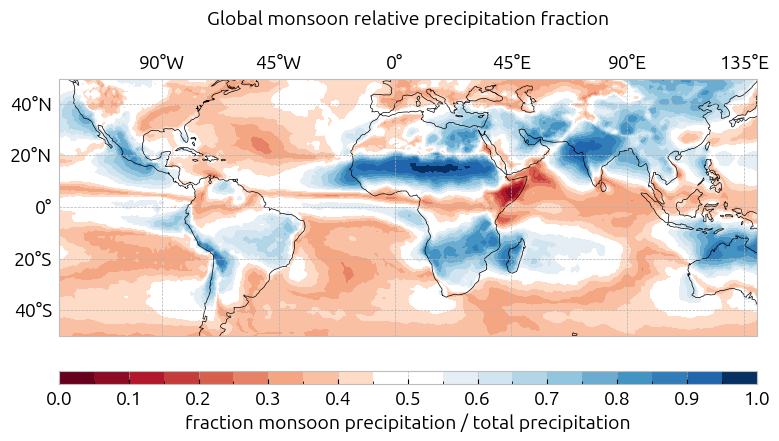

In [68]:
import xarray as xr
reload(tu)
q = 0.6
pr_quantile = tu.compute_quantile(input_data, 0.6)
pr_sum_jjas = tu.compute_sum(pr_jjas)
pr_sum_djfm = tu.compute_sum(pr_djfm)
pr_sum_year = tu.compute_sum(input_data)
rel_frac_jjas = pr_sum_jjas / pr_sum_year
rel_frac_djfm = pr_sum_djfm / pr_sum_year

rel_map = xr.where(
    abs(rel_frac_jjas) > abs(rel_frac_djfm), abs(rel_frac_jjas), rel_frac_djfm
)

im = gplt.plot_map(rel_map,
                   vmin=0, vmax=1,
                   cmap='RdBu',
                   title=f'Global monsoon relative precipitation fraction',
                   centercolor='white',
                   label='fraction monsoon precipitation / total precipitation',
                   levels=20,
                   lon_range=[-130, 140]
                   )

savepath = plot_dir +\
    f"/gm_rel_frac.png"
gplt.save_fig(savepath, fig=im['fig'])

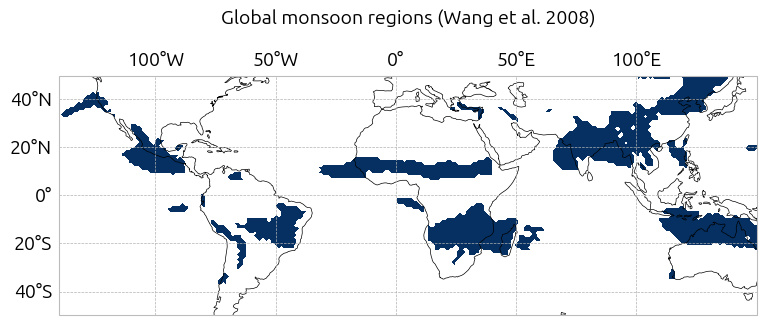

In [77]:
# Global monsoon regions
abs_th = 2
rel_th = 0.6

# Get difference above absolute threshold
diff_map = xr.where(abs(diff_pr) > abs_th, abs(diff_pr), np.nan)
# Get relative difference for 55%
rel_map = xr.where(abs(rel_map) > rel_th, abs(rel_map), np.nan)

# Now combine diff_map and rel_map
m_def = xr.where((rel_map > 0) & (abs(diff_map) > 0), 1, np.nan)
diff_rel_map = xr.where((rel_map > 0) & (abs(diff_map) > 0), diff_map, np.nan)

im = gplt.plot_map(diff_rel_map,
                   vmin=0, vmax=1,
                   cmap='RdBu',
                   title=f'Global monsoon regions (Wang et al. 2008)',
                   centercolor='white',
                   label=None,
                   levels=20,
                   lon_range=[-140, 150]
                   )

savepath = plot_dir +\
    f"/gm_regions.png"
gplt.save_fig(savepath, fig=im['fig'])

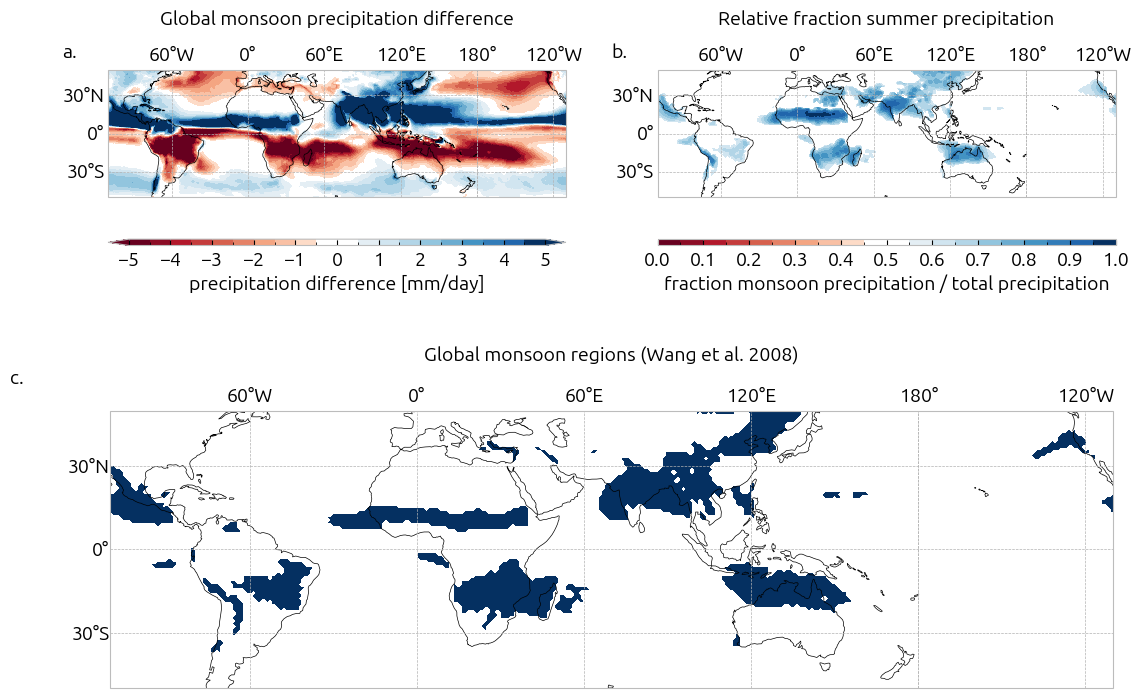

In [80]:
# combine all in one plot
reload(gplt)

im = gplt.create_multi_plot(nrows=2, ncols=2,
                            hspace=0.5,
                            wspace=0.2,
                            full_length_row=True,
                            figsize=(13, 9),
                            projection='PlateCarree',
                            end_idx=3,
                            central_longitude=70,
                            )

map_dict = {
    'diff_map': dict(map=diff_pr, vmin=-5, vmax=5, cmap='RdBu', title='Global monsoon precipitation difference', centercolor='white', label='precipitation difference [mm/day]', levels=20, y_title=1.3),
    'rel_map': dict(map=rel_map, vmin=0, vmax=1, cmap='RdBu', title='Relative fraction summer precipitation', centercolor='white', label='fraction monsoon precipitation / total precipitation', levels=20, y_title=1.3),
    'diff_rel_map': dict(map=diff_rel_map, vmin=0, vmax=1, cmap='RdBu', title='Global monsoon regions (Wang et al. 2008)', centercolor='white', label=None, levels=20, y_title=1.15),
}

for idx, (key, map_dict) in enumerate(map_dict.items()):
    gplt.plot_map(map_dict['map'],
                  vmin=map_dict['vmin'], vmax=map_dict['vmax'],
                  cmap=map_dict['cmap'],
                  title=map_dict['title'],
                  centercolor=map_dict['centercolor'],
                  label=map_dict['label'],
                  levels=map_dict['levels'],
                  lon_range=[-140, 150],
                  ax=im['ax'][idx],
                  y_title=map_dict['y_title'],
                  )

savepath = plot_dir +\
    f"/gm_regions.png"
gplt.save_fig(savepath, fig=im['fig'])

In [66]:
reload(gplt)
gplt.list_available_styles()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']